In [1]:
import torch
import matplotlib.pyplot as plt
from dataloader import MRIDataset
from residual3dunet.model import ResidualUNet3D
from torch.utils.data import Dataset, DataLoader
from utils import dice_coefficient, iou, plotloss, plotaccuracy, compute_average, add_mask_colour
import torchvision.transforms as T
import nibabel as nib
import numpy as np

<Figure size 432x288 with 0 Axes>

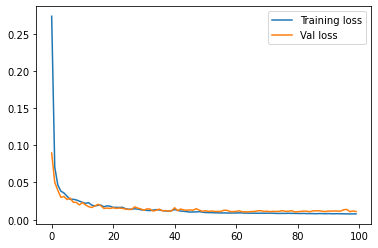

<Figure size 432x288 with 0 Axes>

In [2]:
plotloss('output/train16.out')
plt.figure()
# plotaccuracy('output/train6.out')


In [3]:
device = torch.device('cpu')
model = ResidualUNet3D(in_channels=1, out_channels=1, testing=True).to(device)

model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("model/model16.pt", map_location=device))

<All keys matched successfully>

In [4]:
testdataset = MRIDataset(train=False, transform=T.ToTensor())
test_loader = DataLoader(dataset = testdataset, batch_size=1, shuffle=False)

print(len(test_loader))

image_path = './dataset/train/T1/MRI1_T1.nii.gz'
image_obj = nib.load(image_path)

# Extract data as numpy array
image_data = image_obj.get_fdata()

image_data = np.pad(image_data, ((0,0),(0,0),(0,1)))
image_data = np.moveaxis(image_data, 2, 0)
image_data = np.moveaxis(image_data, 2, 1)
image_data = torch.from_numpy(image_data)
image_data = torch.unsqueeze(image_data, 0)
image_data = torch.unsqueeze(image_data, 0)
# print(image_data.shape)

50


In [37]:
model.eval()

dataiter = iter(test_loader)
data = dataiter.next()
# data = dataiter.next()
# data = dataiter.next()
features, labels = data

features, labels = features.float().to(device), labels.float().to(device)

# image_data = image_data.float().to(device)

output = model(features)

In [27]:
# preds = torch.sigmoid(output)
preds = (output > 0.5).float()

# print(preds.shape)
# print(labels.shape)
batch, channel, depth, width, height = preds.shape

print(iou(preds, labels))
print(dice_coefficient(preds, labels))


RuntimeError: "bitwise_and_cpu" not implemented for 'Float'

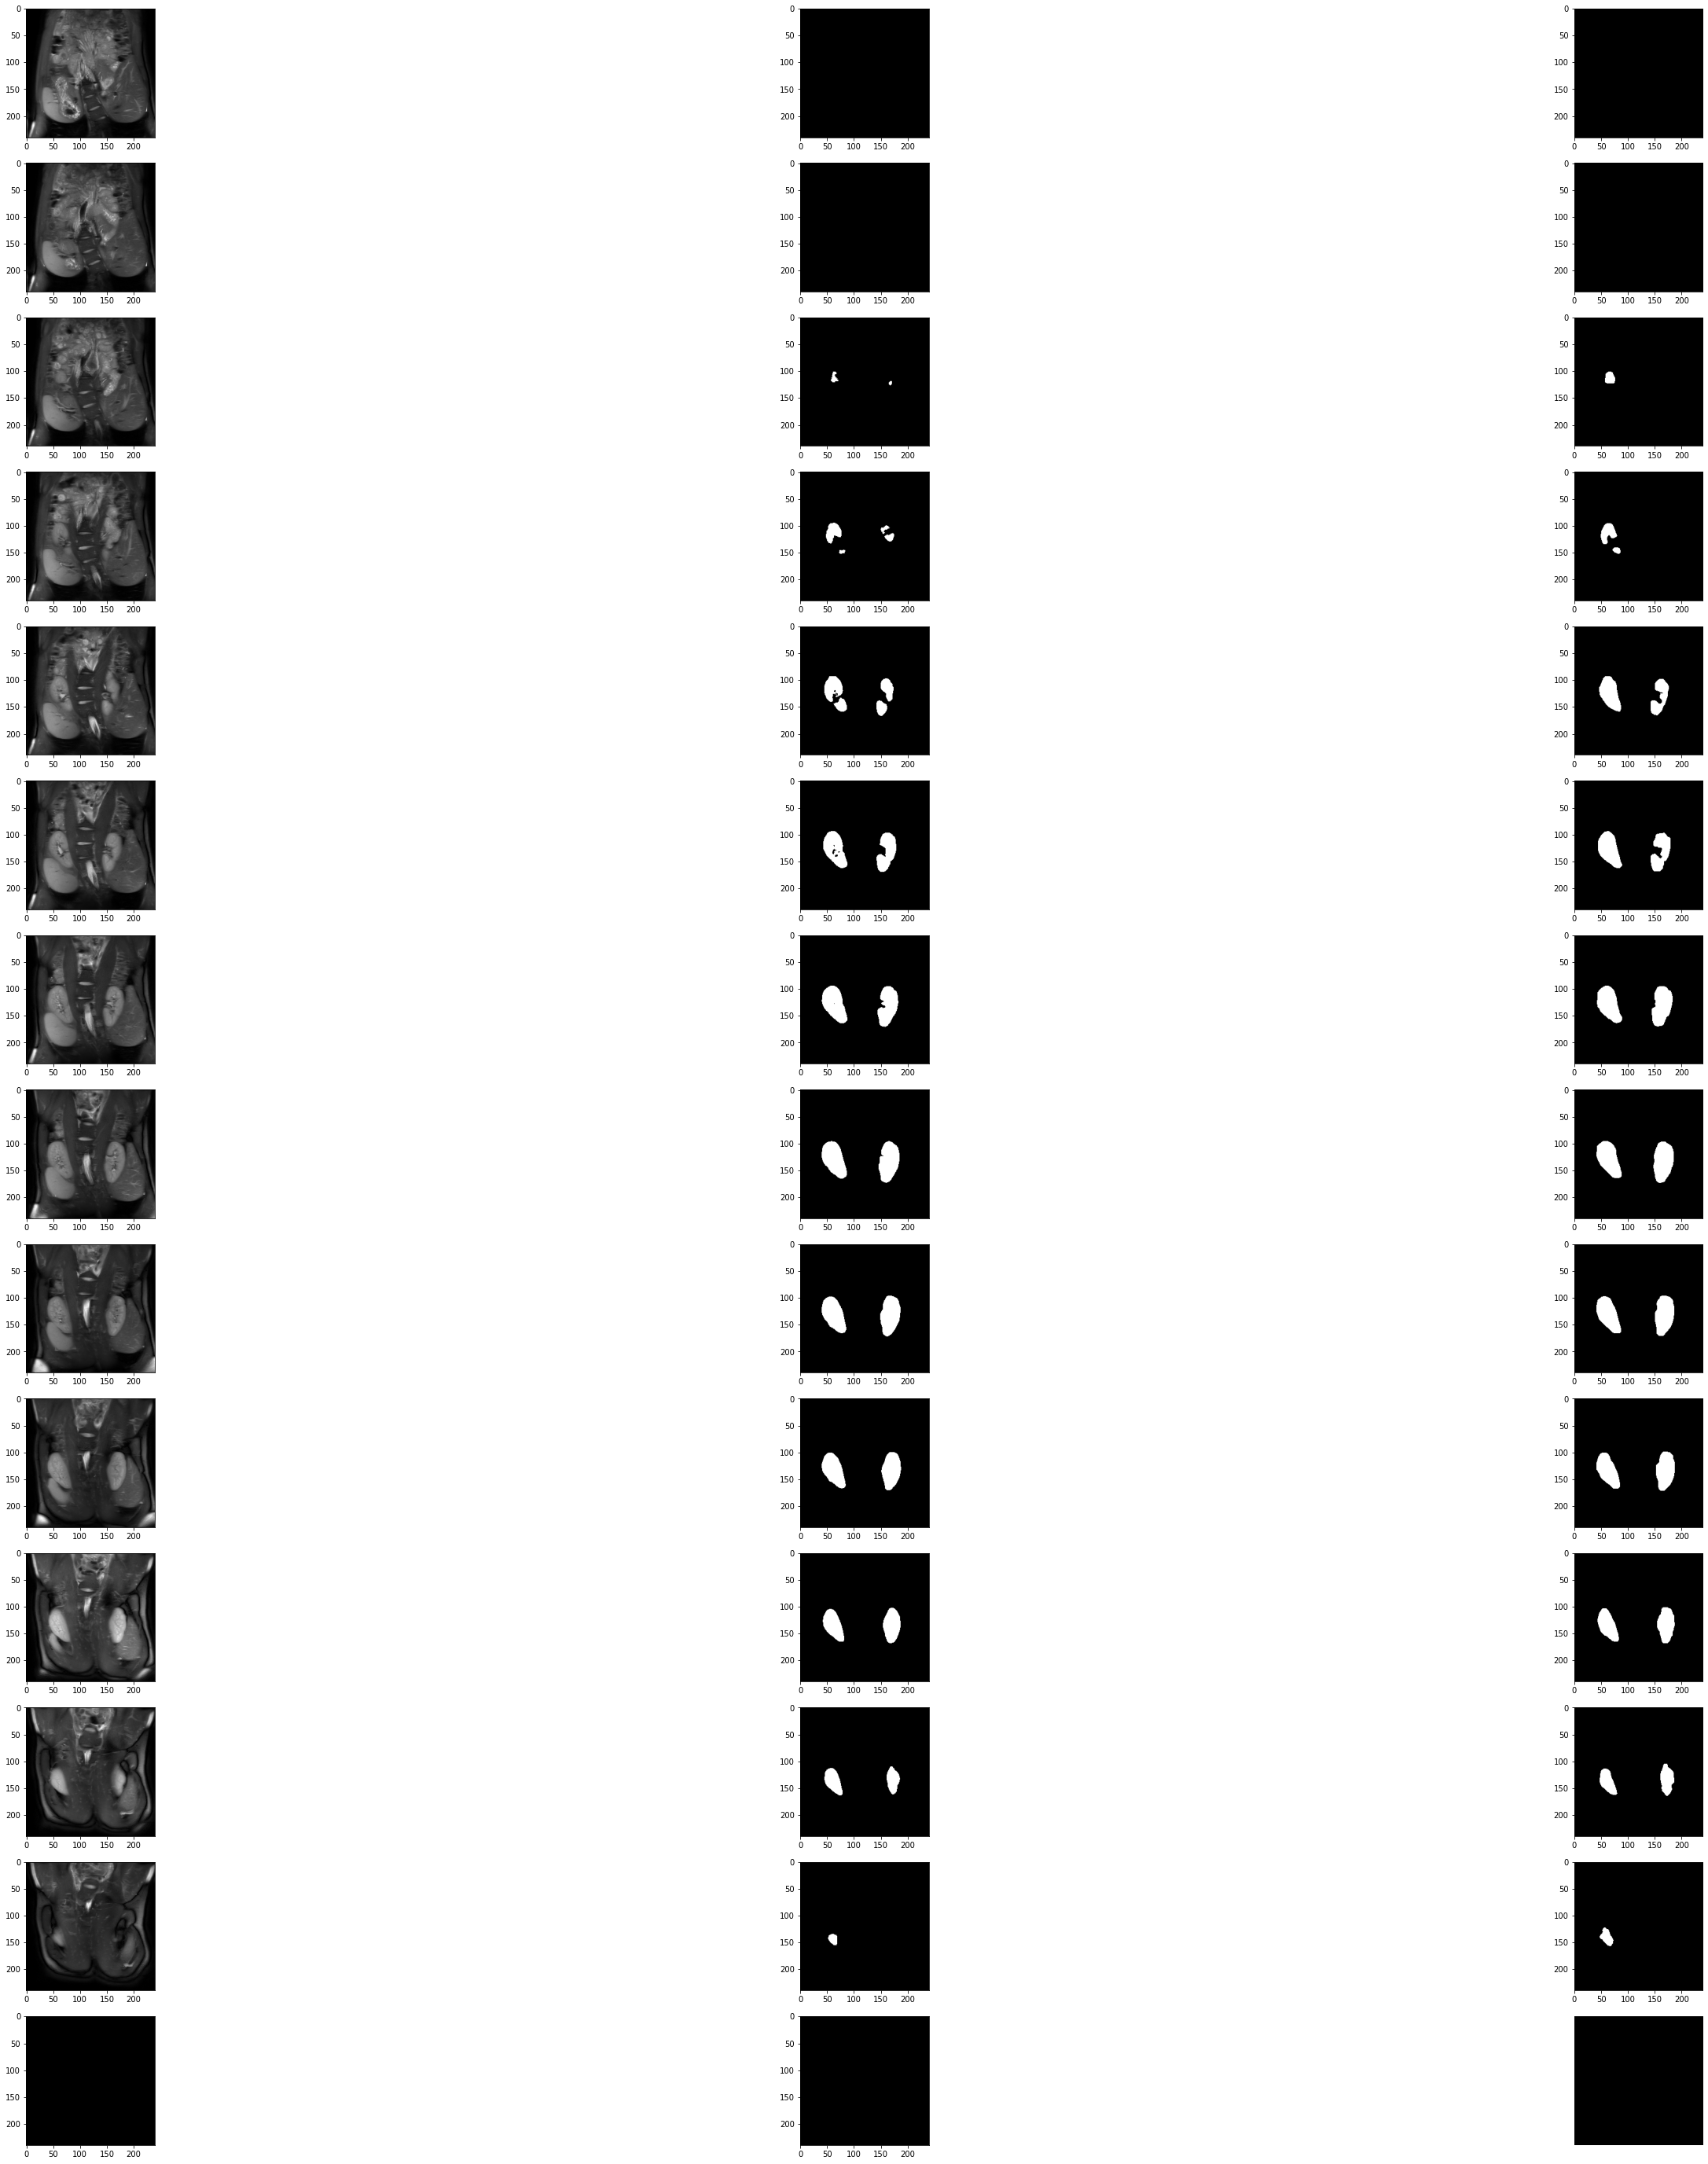

In [29]:
# Visualize Single Image Data
f, axarr = plt.subplots(14,3,figsize=(50,50))

for i in range(depth):
    axarr[i,0].imshow(features[0,0,i,:,:],cmap='gray')
    axarr[i,1].imshow(preds[0,0,i,:,:],cmap='gray')
    axarr[i,2].imshow(labels[0,0,i,:,:],cmap='gray')
    plt.axis('off')

In [22]:
from segmentation_statistics import SegmentationStatistics

preds = preds.numpy()
labels = labels.numpy()
prediction = preds.astype(bool)
gt = labels.astype(bool)

# preds = preds.bool()
# labels = labels.bool()

stat = SegmentationStatistics(prediction[0,0,:,:,:], gt[0,0,:,:,:], (3,2,1))

In [23]:
stat.print_table()

| Metric                |     Score |
|-----------------------|-----------|
| Dice                  |  0.938987 |
| Jaccard               |  0.884991 |
| Sensitivity           |  0.930275 |
| Specificity           |  0.998007 |
| Precision             |  0.947863 |
| Accuracy              |  0.995468 |
| Mean_Surface_Distance |  0.429733 |
| Hausdorff_Distance    |  3        |
| Volume_Difference     | -3.366    |


In [52]:
from ipywidgets import interact

features.shape

# labels = add_mask_colour(labels, "blue")
# preds = add_mask_colour(preds, "red")
# overlap = labels + preds

# print(labels.shape)

def explore_3d_image(layer):
    

    plt.figure(figsize=(5,5))
    plt.imshow(features[0,0,layer,:,:],cmap='gray')
    # plt.imshow(overlap[layer,:,:,:], alpha=0.4)
    plt.title('Explore Segmented MRI')
    plt.axis('off')
    # return layer

interact(explore_3d_image,layer=(0,features.shape[2]-1))

interactive(children=(IntSlider(value=6, description='layer', max=13), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3d_image(layer)>

In [ ]:
f, axarr = plt.subplots(14,2,figsize=(100,100))

for i in range(depth):
    axarr[i,0].imshow(features[0,0,i,:,:],cmap='gray')
    axarr[i,1].imshow(overlap[i,:,:,:],cmap='gray')
    plt.axis('off')